# Ch16

## NLP with RNN

## Setting

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow 2.x selected.
     |████████████████████████████████| 1.0MB 2.8MB/s 
ERROR: tensorflow-federated 0.11.0 requires enum34~=1.1, which is not installed.
ERROR: tensorflow-federated 0.11.0 has requirement attrs~=18.2, but you'll have attrs 19.3.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement cachetools~=3.1.1, but you'll have cachetools 4.0.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement grpcio~=1.24.3, but you'll have grpcio 1.27.2 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement tensorflow~=2.0.0, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement tensorflow-addons~=0.6.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.


## Data Download

In [0]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

## Tokenizing

In [0]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) # toknizing을 할 수 있는 tokenizer을 불러온다
tokenizer.fit_on_texts(shakespeare_text) # 위 텍스트 데이터를 tokenizing할 수있도록 tokenizer를 fitting해준다.

In [4]:
tokenizer.texts_to_sequences(["First"]) # 이런식으로 "First"는 tokenizing되면 다음과 같은 인덱스로 표현됨

[[20, 6, 9, 8, 3]]

In [5]:
tokenizer.word_index

{'\n': 11,
 ' ': 1,
 '!': 31,
 '$': 39,
 '&': 38,
 "'": 28,
 ',': 18,
 '-': 32,
 '.': 27,
 '3': 37,
 ':': 24,
 ';': 29,
 '?': 30,
 'a': 5,
 'b': 22,
 'c': 19,
 'd': 13,
 'e': 2,
 'f': 20,
 'g': 21,
 'h': 7,
 'i': 6,
 'j': 33,
 'k': 25,
 'l': 12,
 'm': 15,
 'n': 10,
 'o': 4,
 'p': 23,
 'q': 34,
 'r': 9,
 's': 8,
 't': 3,
 'u': 14,
 'v': 26,
 'w': 17,
 'x': 35,
 'y': 16,
 'z': 36}

In [0]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [7]:
max_id # 위 텍스트를 구성하는 유니크한 글자들의 종류는 39가지다

39

In [8]:
dataset_size # 위 텍스트를 구성하는 모든 글자의 총 개수

1115394

In [9]:
encoded = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1 #위 텍스트를 전부 tokenizing 한 후 np array에 담아보자, -1을 함으로써 0~38까지 총 39가지
print(encoded)
print(encoded.shape)
encoded = encoded[0] # 이걸로 사용
print(encoded)
print(encoded.shape)
train_size = dataset_size * 40 // 100 # 20%를 트레이닝 셋으로 사용하자
train = encoded[:train_size] # 엄청나게 많은 글자가 연속된 하나의 텍스트임
# --> 여러개의 데이터로 적절히 잘라서 구성할 필요가 있음(rolling window방식으로 데이터를 구성해야 함)
print('len of train set')
print(train.shape)

[[19  5  8 ... 20 26 10]]
(1, 1115394)
[19  5  8 ... 20 26 10]
(1115394,)
len of train set
(446157,)


## long single text data to short multiple data for rolling window

In [0]:
def window(data, win_len): # 다음 101번째 글자를 예측해 보겠다.
  _x = []
  _y = []
  for idx in range(len(data) - win_len - 1 ):
    _x.append(data[idx:idx + win_len]) # 0:0+100 --> 0~99번째, 1:1+100 --> 1~100번째, ...
    _y.append(data[idx+win_len]) # 0+100 = 100번째, 1+100 = 101번째, ...

  return np.array(_x), np.array(_y)


win_len = 100 # 100개의 step을 input으로 넣는다
X_train, y_train = window(train, win_len)

In [11]:
train[0:102]

array([19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
       19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
        9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0,
       14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7,
       22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,
        7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13,  0,  4])

In [12]:
X_train[0]

array([19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
       19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
        9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0,
       14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7,
       22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,
        7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13])

In [13]:
y_train[0]

0

In [14]:
X_train[1]

array([ 5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1, 19,
        3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,  9,
       15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0, 14,
        1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7, 22,
        1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,  7,
        2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13,  0])

In [15]:
y_train[1]

4

## Data Shuffling

In [0]:
idx = np.random.choice(5,5,replace=False)

In [0]:
a = np.array(['a', 'b', 'c', 'd', 'e'])

In [18]:
idx

array([1, 4, 2, 0, 3])

In [19]:
a[idx]

array(['b', 'e', 'c', 'a', 'd'], dtype='<U1')

In [20]:
def shuffle(X_train, y_train):
  size = X_train.shape[0]
  rand_idx = np.random.choice(size, size,replace=False) # size-1 까지의 index를(비복원 추출 = index는 중복되면 안됨) size만큼의 길이를 갖는 array를 뱉어냄
  print(rand_idx)
  print(rand_idx.shape)
  return X_train[rand_idx], y_train[rand_idx], rand_idx

X_train_shuffled, y_train_shuffled, rand_idx = shuffle(X_train, y_train)
print(X_train_shuffled.shape)
print(y_train_shuffled.shape)

[383918 339071  49548 ... 207892 110268 119879]
(446056,)
(446056, 100)
(446056,)


In [21]:
train[rand_idx[0]:rand_idx[0]+win_len]

array([20,  7, 17,  0,  1,  4,  7,  5, 11, 15,  0, 16,  3,  9,  0,  2,  3,
        0, 19,  4, 16,  9,  0,  3,  9,  0,  4,  9, 15,  0, 14,  4,  9, 30,
       10,  7,  9,  4, 24,  1,  7, 17,  0,  5,  9,  0, 14, 15,  0,  6,  1,
        4,  8,  2, 31, 21, 11,  3,  3, 12,  0, 16,  4,  8, 14, 27, 12, 17,
        0,  2,  6,  4,  2,  0,  7,  2,  5,  9, 20,  0, 14, 15,  0,  6,  1,
        4,  8,  2, 30, 10,  2,  6,  8,  1,  1,  0, 32, 13, 12,  4])

In [22]:
train[rand_idx[0]+win_len]

7

In [23]:
X_train[rand_idx[0]]

array([20,  7, 17,  0,  1,  4,  7,  5, 11, 15,  0, 16,  3,  9,  0,  2,  3,
        0, 19,  4, 16,  9,  0,  3,  9,  0,  4,  9, 15,  0, 14,  4,  9, 30,
       10,  7,  9,  4, 24,  1,  7, 17,  0,  5,  9,  0, 14, 15,  0,  6,  1,
        4,  8,  2, 31, 21, 11,  3,  3, 12,  0, 16,  4,  8, 14, 27, 12, 17,
        0,  2,  6,  4,  2,  0,  7,  2,  5,  9, 20,  0, 14, 15,  0,  6,  1,
        4,  8,  2, 30, 10,  2,  6,  8,  1,  1,  0, 32, 13, 12,  4])

In [24]:
X_train_shuffled[0]

array([20,  7, 17,  0,  1,  4,  7,  5, 11, 15,  0, 16,  3,  9,  0,  2,  3,
        0, 19,  4, 16,  9,  0,  3,  9,  0,  4,  9, 15,  0, 14,  4,  9, 30,
       10,  7,  9,  4, 24,  1,  7, 17,  0,  5,  9,  0, 14, 15,  0,  6,  1,
        4,  8,  2, 31, 21, 11,  3,  3, 12,  0, 16,  4,  8, 14, 27, 12, 17,
        0,  2,  6,  4,  2,  0,  7,  2,  5,  9, 20,  0, 14, 15,  0,  6,  1,
        4,  8,  2, 30, 10,  2,  6,  8,  1,  1,  0, 32, 13, 12,  4])

In [25]:
y_train[rand_idx[0]]

7

In [26]:
y_train_shuffled[0]

7

## one hot encoding

In [0]:
X_train_one_hot = tf.one_hot(X_train, depth=max_id)
y_train_one_hot = tf.one_hot(y_train, depth=max_id)

In [28]:
X_train_one_hot

<tf.Tensor: shape=(446056, 100, 39), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1.,

In [29]:
y_train_one_hot

<tf.Tensor: shape=(446056, 39), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## training

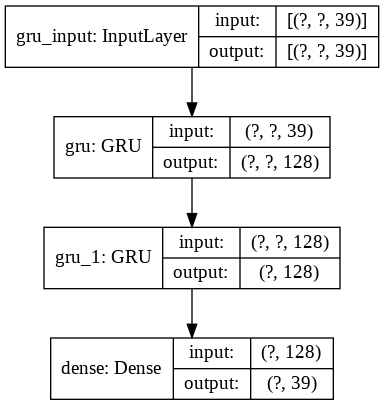

In [30]:

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128),
    keras.layers.Dense(max_id, activation="softmax"),
])
keras.utils.plot_model(model, show_shapes=True)

In [31]:
batch_size = 1024
model.compile(loss="categorical_crossentropy", optimizer="adam")
history = model.fit(X_train_one_hot, y_train_one_hot, batch_size=batch_size, epochs=20)

Train on 446056 samples
Epoch 1/20
446056/446056 [==============================] - 63s 141us/sample - loss: 2.4078
Epoch 2/20
446056/446056 [==============================] - 60s 134us/sample - loss: 1.9110
Epoch 3/20
446056/446056 [==============================] - 59s 133us/sample - loss: 1.7136
Epoch 4/20
446056/446056 [==============================] - 60s 133us/sample - loss: 1.6042
Epoch 5/20
446056/446056 [==============================] - 60s 133us/sample - loss: 1.5365
Epoch 6/20
446056/446056 [==============================] - 59s 133us/sample - loss: 1.4883
Epoch 7/20
446056/446056 [==============================] - 60s 134us/sample - loss: 1.4512
Epoch 8/20
446056/446056 [==============================] - 60s 134us/sample - loss: 1.4221
Epoch 9/20
446056/446056 [==============================] - 59s 133us/sample - loss: 1.3967
Epoch 10/20
446056/446056 [==============================] - 59s 133us/sample - loss: 1.3759
Epoch 11/20
446056/446056 [============================

## test

In [127]:
test_size = dataset_size * 1 // 100 # 20%를 트레이닝 셋으로 사용하자
print(test_size)
test = encoded[train_size:train_size+test_size] # 엄청나게 많은 글자가 연속된 하나의 텍스트임
print(train_size)

11153
446157


In [128]:
test.shape

(11153,)

In [0]:
X_test, y_test = window(test, win_len)

In [0]:
X_test_one_hot = tf.one_hot(X_test[0:2], depth=max_id)
y_test_one_hot = tf.one_hot(y_test[0:2], depth=max_id)

In [131]:
X_test_one_hot

<tf.Tensor: shape=(2, 100, 39), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [132]:
y_test_one_hot

<tf.Tensor: shape=(2, 39), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [133]:
y_test_one_hot[0]

<tf.Tensor: shape=(39,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)>

In [134]:
y_test_one_hot[1]

<tf.Tensor: shape=(39,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)>

In [136]:
y_pred = model.predict_classes(X_test_one_hot) # 예측된 y 값(글자)의 index를 알아냄
# y_pred_one_hot = tf.one_hot(y_pred, depth=max_id)
y_pred

array([18,  1])

In [137]:
tokenizer.word_index

{'\n': 11,
 ' ': 1,
 '!': 31,
 '$': 39,
 '&': 38,
 "'": 28,
 ',': 18,
 '-': 32,
 '.': 27,
 '3': 37,
 ':': 24,
 ';': 29,
 '?': 30,
 'a': 5,
 'b': 22,
 'c': 19,
 'd': 13,
 'e': 2,
 'f': 20,
 'g': 21,
 'h': 7,
 'i': 6,
 'j': 33,
 'k': 25,
 'l': 12,
 'm': 15,
 'n': 10,
 'o': 4,
 'p': 23,
 'q': 34,
 'r': 9,
 's': 8,
 't': 3,
 'u': 14,
 'v': 26,
 'w': 17,
 'x': 35,
 'y': 16,
 'z': 36}

In [0]:
#print(shakespeare_text)

In [142]:
# X_test의 첫번째 문장 --> 출력값으로 c가 나와야함
tokenizer.sequences_to_texts([X_test[0] + 1]) # +1 해줘야 원래 index에서 -1빼준걸 원래대로 돌려 놓을 수 있음

['i n   c a p u l e t , - - h o l d   m e   n o t ,   l e t   m e   g o . \n \n l a d y   m o n t a g u e : \n t h o u   s h a l t   n o t   s t i r   a   f o o t   t o   s e e k   a   f o e . \n \n p r i n']

In [154]:
# X_test의 두번째 문장 --> 출력값으로 e가 나와야함
tokenizer.sequences_to_texts([X_test[1] + 1]) # +1 해줘야 원래 index에서 -1빼준걸 원래대로 돌려 놓을 수 있음

['n   c a p u l e t , - - h o l d   m e   n o t ,   l e t   m e   g o . \n \n l a d y   m o n t a g u e : \n t h o u   s h a l t   n o t   s t i r   a   f o o t   t o   s e e k   a   f o e . \n \n p r i n c']

In [153]:
# y_pred의 결과 --> 출력값으로 c랑 e가 나와야함
tokenizer.sequences_to_texts([y_pred + 1]) # +1 해줘야 원래 index에서 -1빼준걸 원래대로 돌려 놓을 수 있음

['c e']

# Sentiment Analysis

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


In [9]:
X_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [10]:
X_train.shape # 25000개의 리뷰 데이터

(25000,)

In [14]:
# 각 리뷰의 길이는 다 다름
print(len(X_train[0]))
print(len(X_train[20]))

218
129


In [17]:
print(y_train)
print(y_train.shape) # 25000개의 정답 레이블: 1-positive vs 0-negative

[1 0 0 ... 0 1 0]
(25000,)


## pad_sequences

In [57]:
maxlen = 500

# Pads sequences to the same length.
# shape = (num_samples, num_timesteps), num_timesteps = maxlen
# Sequences가 num_timesteps 보다 짧으면 zero padding. Pre-padding is the default.
# Sequences가 num_timesteps 길면 truncate. Pre-truncate is the default.

x_train_ = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_ = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



x_train shape: (25000,)
x_test shape: (25000,)


In [58]:
print(x_train[0])
print(len(x_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218


In [59]:
print(x_train_[0])
print(len(x_train_[0]))

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [60]:
maxlen = 100

x_train_ = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_ = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



x_train shape: (25000,)
x_test shape: (25000,)


In [61]:
print(x_train[0])
print(len(x_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218


In [62]:
print(x_train_[0])
print(len(x_train_[0]))

[ 1415    33     6    22    12   215    28    77    52     5    14   407
    16    82 10311     8     4   107   117  5952    15   256     4 31050
     7  3766     5   723    36    71    43   530   476    26   400   317
    46     7     4 12118  1029    13   104    88     4   381    15   297
    98    32  2071    56    26   141     6   194  7486    18     4   226
    22    21   134   476    26   480     5   144    30  5535    18    51
    36    28   224    92    25   104     4   226    65    16    38  1334
    88    12    16   283     5    16  4472   113   103    32    15    16
  5345    19   178    32]
100


In [66]:
print(y_train)

[1 0 0 ... 0 1 0]


In [70]:
x_train_.shape

(25000, 100)

In [71]:
y_train.shape

(25000,)

## full code

In [0]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

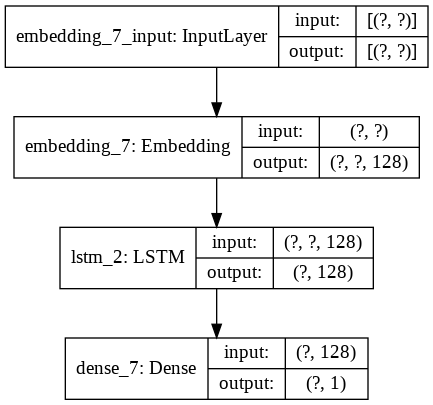

In [83]:
# Embedding layer
##Turns 양의 정수 값을 갖는 index를 dense vectors of fixed size로 변환(워드 임베딩). eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
##This layer can only be used as the first layer in a model.

model = keras.models.Sequential()
model.add(keras.layers.Embedding(max_features, 128))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))
keras.utils.plot_model(model, show_shapes=True)

In [82]:
batch_size = 32
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=1)
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 25000 samples
25000/25000 [==============================] - 4s 154us/sample - loss: 0.3649 - accuracy: 0.8413
Test score: 0.36490911024093625
Test accuracy: 0.84132
